# Reduce the size of an old dataset

In [ ]:
from data.swarmset import SwarmDataset
import numpy as np
import cv2

def resizeInput(X, w=200):
    frame = X.astype(np.uint8)
    resized = cv2.resize(frame, dsize=(w, w), interpolation=cv2.INTER_AREA)
    return resized

from_data = SwarmDataset("data/full-dual-sensors")
to_data = SwarmDataset("data/full-mini-dual")

for i in range(len(from_data)):
    image, genome, behavior = from_data[i][0], from_data[i][1], from_data[i][2]
    image = resizeInput(image, 50)
    to_data.new_sample(image, genome, behavior)

In [ ]:
from networks.embedding import NoveltyEmbedding

old = NoveltyEmbedding(out_size=5)
new = NoveltyEmbedding(out_size=5, new_model=True)

old_count = sum(p.numel() for p in old.parameters() if p.requires_grad)
new_count = sum(p.numel() for p in new.parameters() if p.requires_grad)
print(old_count, new_count)

In [ ]:
from data.swarmset import SwarmDataset
import matplotlib.pyplot as plot
data = SwarmDataset("data/human-mini")

i = 91
plot.imshow(data[i][0], cmap="Greys")
print(data[i][1])

In [ ]:
import cv2
import random
import matplotlib.pyplot as plot
from data.swarmset import SwarmDataset
import matplotlib.pyplot as plot
from scipy import ndimage
import numpy as np

def resizeInput(X, w=200):
    frame = X.astype(np.uint8)
    resized = cv2.resize(frame, dsize=(w, w), interpolation=cv2.INTER_AREA)
    return resized

def translate(img, offset=(10, 10)):
    h, w = img.shape
    xoff, yoff = offset
    if xoff < 0: xpadding = (0, -xoff)
    else: xpadding = (xoff, 0)
    if yoff < 0: ypadding = (0, -yoff)
    else: ypadding = (yoff, 0)
    img = np.pad(img, (xpadding, ypadding))

    if xoff >= 0 and yoff >= 0:
        return img[:w, :w]
    elif xoff < 0 and yoff >= 0:
        return img[-w:, :w]
    elif xoff >= 0 and yoff < 0:
        return img[:w, -w:]
    return img[-w:, -w:]

def zoom_at(img, zoom, coord=None):
    # Adapted from https://stackoverflow.com/questions/69050464/zoom-into-image-with-opencv
    h, w = [ zoom * i for i in img.shape ]
    if coord is None: cx, cy = w/2, h/2
    else: cx, cy = [ zoom*c for c in coord ]
    img = cv2.resize( img, (0, 0), fx=zoom, fy=zoom)
    img = img[ int(round(cy - h/zoom * .5)) : int(round(cy + h/zoom * .5)),
               int(round(cx - w/zoom * .5)) : int(round(cx + w/zoom * .5))]
    return img

data = SwarmDataset("data/tinytoy")

plot.imshow(data[70][0], cmap="Greys")
plot.show()

rot = ndimage.rotate(data[70][0], 90)
rot = resizeInput(rot, 50)
plot.imshow(rot, cmap="Greys")
# plot.imshow(ndimage.gaussian_filter(data[60][0], sigma=1.5), cmap="Greys")
plot.show()

# Cosine Similarity in Pretraining

In [ ]:
import torch
import cv2
import random
import matplotlib.pyplot as plot
from data.swarmset import SwarmDataset
from scipy import ndimage
import numpy as np
from networks.ensemble import Ensemble

PRETRAINING = True
target = 0.01
loss = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ensemble = Ensemble(size=3, output_size=5, lr=6e-4, learning_decay=0.95, decay_step=3, margin=10, init="Random", new_model=True)
ensemble.load_ensemble("toy-test-mixed-D")

data = SwarmDataset("data/tinytoy")
image = data[400][0]
primary_embedding = ensemble.ensemble[0].numpy_single_pass(image).cpu().detach()

cosine_scores = []
for i in range(len(data)):
    potential_negative = data[i][0]
    embedding = ensemble.ensemble[0].numpy_single_pass(potential_negative).cpu().detach().numpy().T
    cosine_sim = np.dot(primary_embedding, embedding)/(np.linalg.norm(primary_embedding)*np.linalg.norm(embedding))
    cosine_scores.append((cosine_sim, i))

cosine_scores.sort()
top_five = cosine_scores[:5]
print(top_five)

print("TARGET:")
plot.imshow(image, cmap="Greys")
plot.show()

for score, i in top_five:
    print(f"{i}, Score: {score}")
    plot.imshow(data[i][0], cmap="Greys")
    plot.show()

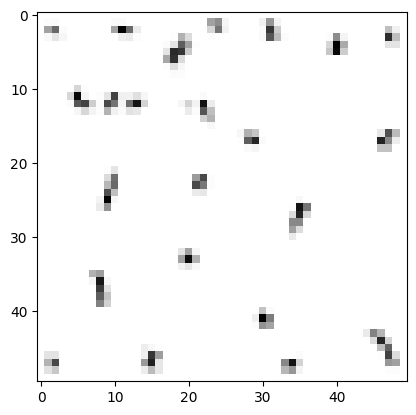

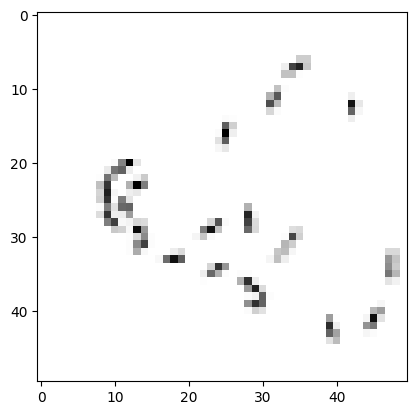

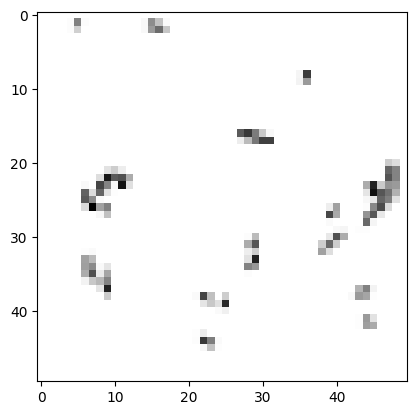

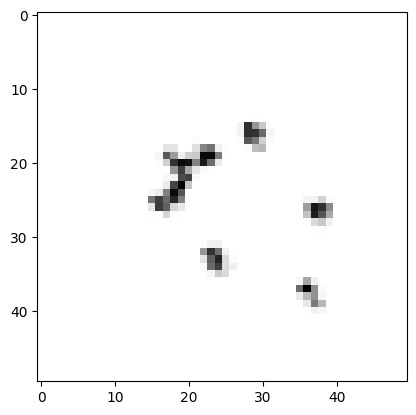

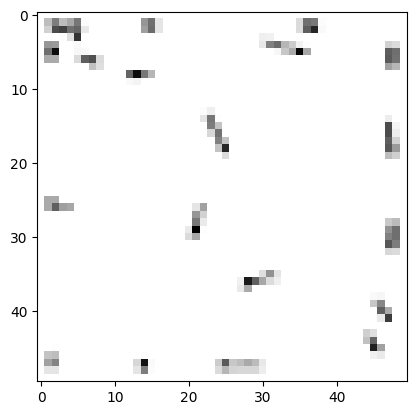

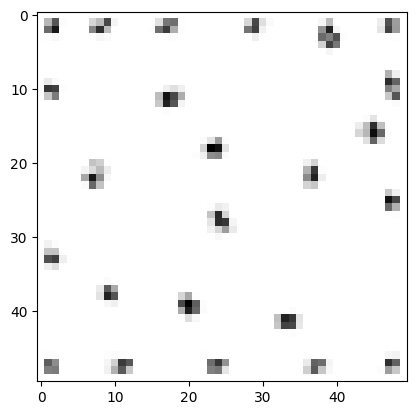

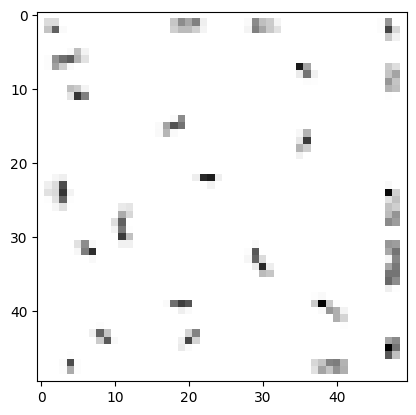

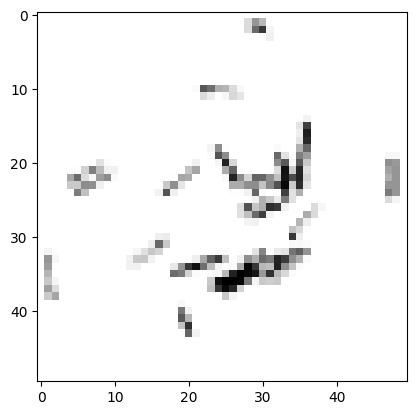

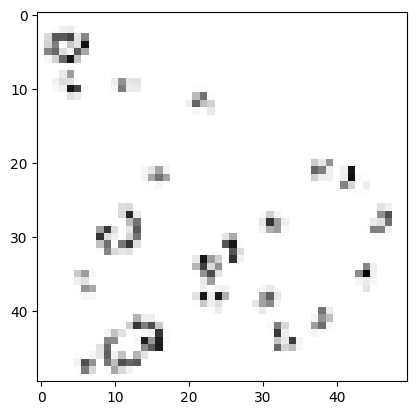

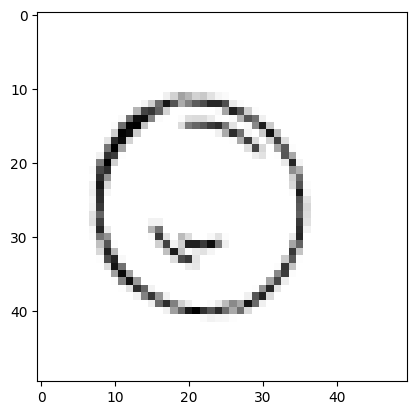

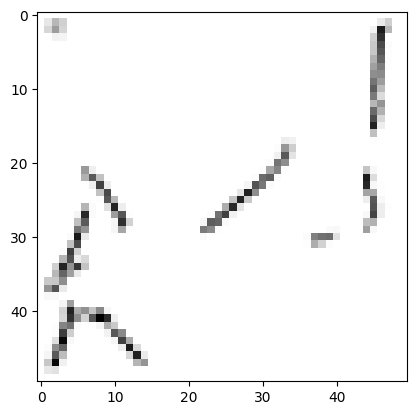

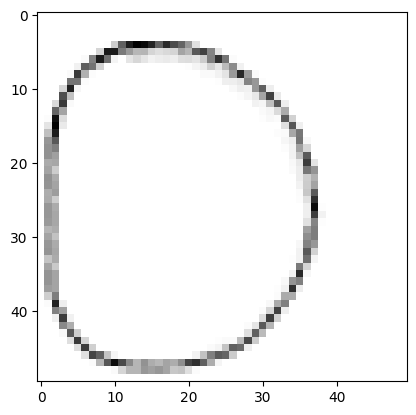

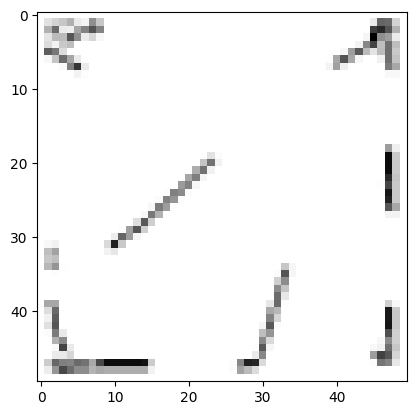

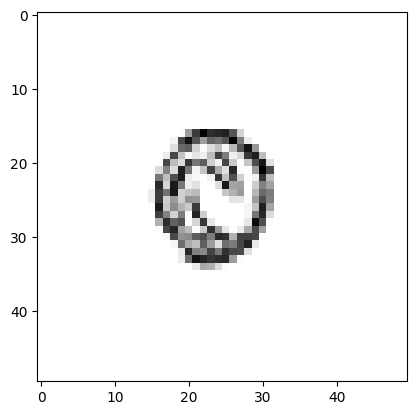

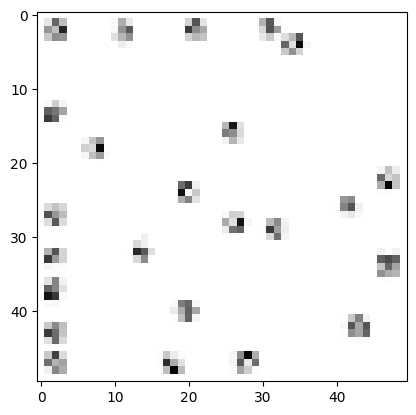

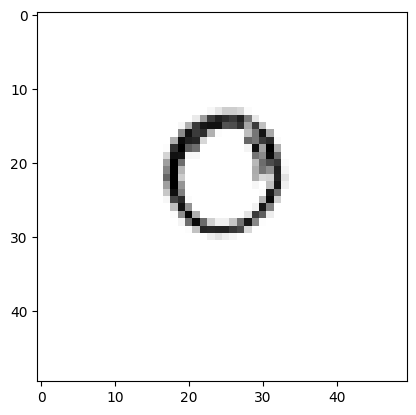

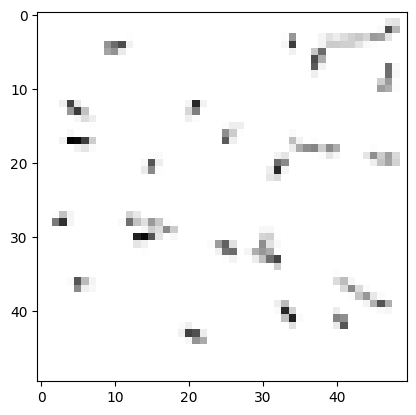

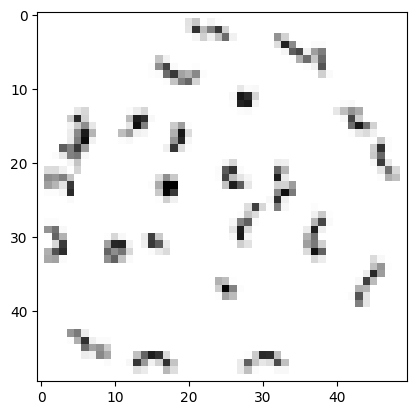

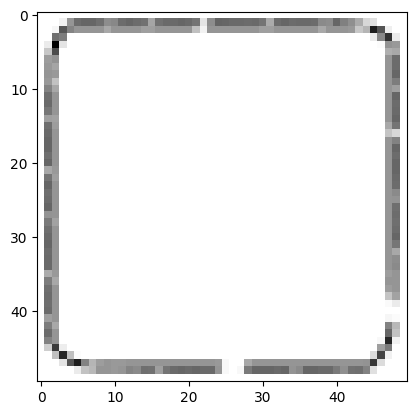

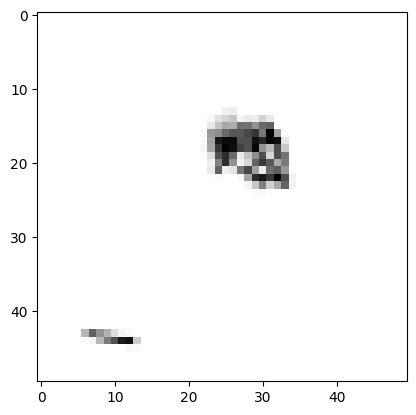

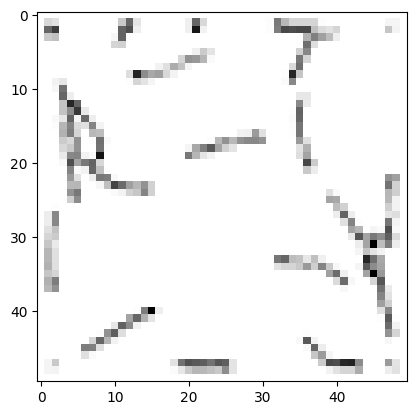

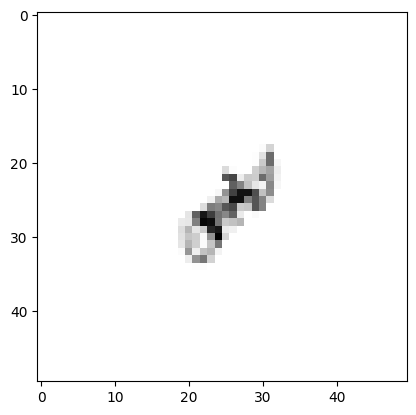

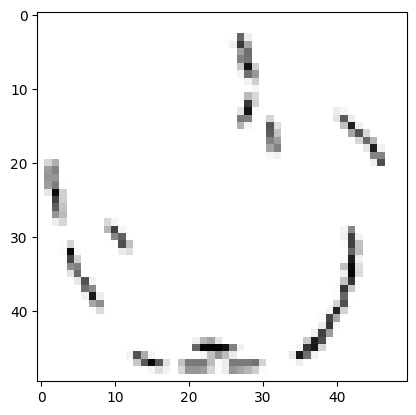

177, 4
178, 0
179, 0
180, 3
181, 0
182, 4
183, 0
184, 0
185, 0
186, 6
187, 0
188, 2
189, 0
190, -1 2
191, 0
192, 2
193, 0
194, 0
195, 5
196, 3
197, 0
198, 3
199, 0



In [6]:
# Labeling Training Data
from data.swarmset import SwarmDataset
import matplotlib.pyplot as plt
import time
data = SwarmDataset("data/validation-two-sensor-model")
START = 0

pairs = ""
for i in range(START, len(data)):
    _inp = data[i][0]
    plt.imshow(_inp, cmap="Greys")
    plt.show()
    time.sleep(1.2)
    _class = input("Classification? ")
    if _class == None or _class == "":
        break
    pairs += f"{i}, {_class}\n"

print(pairs)

In [ ]:
# Count the Proportions of classes given an I.I.D sampling of the behavior space
from data.swarmset import SwarmDataset
import matplotlib.pyplot as plt
import time
import os
def CSVLineToVec(line):
    line_list = line.strip().replace("\n", "").split(",")
    float_list = []
    for i in line_list:
        float_list.append(float(i))
    float_list = np.array(float_list)
    return float_list

data = SwarmDataset("data/full-mini")
lim = len(data)
classes = [-1 for i in range(lim)]

OUT = "data/oracle"
with open(os.path.join(OUT, "original-hand-labeled-classes.txt"), "r") as f:
    lines = f.readlines()
    for line in lines:
        triplet = CSVLineToVec(line)
        classes[int(triplet[0])] = int(triplet[1])

class_dict = {i:0 for i in range(-1, max(classes) + 1)}
for data in classes:
    class_dict[data] += 1

print(class_dict)

y = [class_dict[l] for l in range(0, 6)]
x = [l for l in range(0, 6)]
plt.bar(x, y)
plt.xticks(x, labels=["Random", "Cyclic", "Milling", "Agg.", "Dispersal", "Wall F."])
plt.title("Class labels for 250 i.i.d. samples from the R^4 Controller Space")
plt.ylabel("Samples Generated")

# Map Behaviors to the Controller Space, project into 2D

In [ ]:
import torch
import time
from data.swarmset import ContinuingDataset, SwarmDataset
from networks.embedding import NoveltyEmbedding
from networks.archive import DataAggregationArchive
from networks.ensemble import Ensemble
import numpy as np
from scipy import ndimage
import random
from sklearn.manifold import TSNE

sampled_dataset = SwarmDataset("data/full-mini", rank=0)
data = sampled_dataset

lim = 1000
embeddings = []
classes = [-1 for i in range(lim)]
for i in range(lim):
    image, genome, behavior = sampled_dataset[i][0], sampled_dataset[i][1], sampled_dataset[i][2]
    for j in range(len(behavior)):
        if behavior[j] < 0.0:
            behavior[j] *= -1
    embeddings.append(behavior)

with open(os.path.join(OUT, "original-hand-labeled-classes.txt"), "r") as f:
    lines = f.readlines()
    for line in lines:
        triplet = CSVLineToVec(line)
        classes[int(triplet[0])] = int(triplet[1])

embeddings.append([1.252829225737955, 0.3306611079745136, 0.10185270664281239, 0.08166410678402125, 1.1257187120563563]) # Windmill
classes.append(6)
embeddings.append([1.156806429844155, -0.17863707928684217, 0.3291847462779318, 0.07660598058604781, -0.5923099508105084]) # Nested Cycles
classes.append(6)
embeddings.append([0.9929654922699359, 0.09833733667253076, 0.05782206407062742, 0.02105642976502228, 0.7106113280473935]) # Special Cycles
classes.append(6)

embeddings = np.array(embeddings)

In [ ]:
reduced = TSNE(
    n_components=2,
    learning_rate="auto",
    init="pca",
    perplexity=50,
    early_exaggeration=14
).fit_transform(embeddings)

In [ ]:
import matplotlib.pyplot as plot

color_classes = {
    -1: [0.33, 0.33, 0.33],
    0: [1, 0, 0],
    1: [0, 1, 0],
    2: [0, 0, 1],
    3: [0, 1, 1], # Cyan
    4: [1, 1, 0], # Yellow
    5: [0.5, 0, 0.25], # Pink
    6: [0, 0, 0]
}

label_classes = {
    -1: "Unlabeled",
    0: "Random",
    1: "Cyclic Pursuit",
    2: "Milling",
    3: "Aggregation",
    4: "Dispersal",
    5: "Wall Following",
    6: "Special"
}

lim = len(reduced)
RANDOM = -1
x = [reduced[i][0] for i in range(lim) if classes[i] != RANDOM]
y = [reduced[i][1] for i in range(lim) if classes[i] != RANDOM]
colors = [color_classes[classes[i]] for i in range(lim)  if classes[i] != RANDOM]
labels = [label_classes[classes[i]] for i in range(lim)  if classes[i] != RANDOM]
# plot.grid(True)
plot.scatter(x, y, c=colors)
plot.legend()

In [ ]:
reduced = TSNE(
    n_components=3,
    learning_rate="auto",
    init="pca",
    perplexity=200,
    early_exaggeration=4
).fit_transform(embeddings)

In [ ]:
import matplotlib.pyplot as plot

color_classes = {
    -1: [0.33, 0.33, 0.33],
    0: [1, 0, 0],
    1: [0, 1, 0],
    2: [0, 0, 1],
    3: [0, 1, 1], # Cyan
    4: [1, 1, 0], # Yellow
    5: [0.5, 0, 0.25], # Pink
    6: [0, 0, 0]
}

label_classes = {
    -1: "Unlabeled",
    0: "Random",
    1: "Cyclic Pursuit",
    2: "Milling",
    3: "Aggregation",
    4: "Dispersal",
    5: "Wall Following",
    6: "Special"
}

lim = len(reduced)
RANDOM = -1
x = [reduced[i][0] for i in range(lim) if classes[i] != RANDOM]
y = [reduced[i][1] for i in range(lim) if classes[i] != RANDOM]
z = [reduced[i][2] for i in range(lim) if classes[i] != RANDOM]
colors = [color_classes[classes[i]] for i in range(lim)  if classes[i] != RANDOM]
# labels = [label_classes[classes[i]] for i in range(lim)  if classes[i] != RANDOM]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z, c=colors)
# ax.set_xlim(-2.0, 1.2)
ax.set_ylim(-1.5, 5)
ax.set_zlim(-2, 2)
ax.set_title("Hand-Crafted Behavior Space")
ax.set_xlabel("t-SNE X Projection")
ax.set_ylabel("t-SNE Y Projection")
ax.set_zlabel("t-SNE Z Projection")
ax.legend()

plt.show()

In [ ]:
import random
import torch
import os
import numpy as np
from networks.ensemble import Ensemble
from data.swarmset import ContinuingDataset, SwarmDataset
PRETRAINING = True
target = 0.01
loss = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ensembleA = Ensemble(size=5, output_size=5, lr=6e-4, learning_decay=0.95, decay_step=3)